In [52]:
import Flux
import Plots

In [53]:
push!(LOAD_PATH, "/home/dylan/ThesisWorkspace/Julia/ThinLens")
import ThinLens as TL

# set up model

In [54]:
particle = [-8.16e-03, -1.78e-03,  5.55e-03,  1.93e-03,  0.00e+00,  7.87e-04, 9.99e-01]

7-element Vector{Float64}:
 -0.00816
 -0.00178
  0.00555
  0.00193
  0.0
  0.000787
  0.999

In [55]:
beam = TL.Beam(mass=18.798, energy=19.0, ϵx=1.258e-6, ϵy=2.005e-6, charge=1, sigt=0.1, sige=1e-2)

particles = TL.ParticlesGaussian(beam, 500)

7×500 Matrix{Float64}:
 -0.000317437   0.00131671   0.00200596   …  -0.000698962   0.00162136
  0.000465954   0.00281289  -0.00468557       0.0018169     0.00172353
 -0.00543024   -0.00444091   0.00521316      -0.000210463  -0.00306796
  6.89748e-5    0.00199109  -0.00432064      -0.00418401    0.000169799
 -0.0427229     0.112734    -0.0959752       -0.0251651     0.0149931
  0.000114116  -0.00356589  -0.000421109  …  -0.00164706    0.00127693
  0.999888      1.0035       1.00041          1.00161       0.998752

In [56]:
model = TL.Lattice.SIS18_Lattice(0.32, -0.28, 0., 0.);
accelerator = TL.Lattice.SIS18_Lattice(0.3100082065838593, -0.2699415513037751, 0., 0.);

In [57]:
# turns = 3
# model = TL.FlatChain([model for _ in 1:turns]);
# accelerator = TL.FlatChain([accelerator for _ in 1:turns]);

In [58]:
TL.track(accelerator, particle)

7×12×1 PermutedDimsArray(::Array{Float64, 3}, (1, 3, 2)) with eltype Float64:
[:, :, 1] =
 -0.00814121   0.0215254   -0.0132524    …   0.0109977    -0.0191847
  0.00350923  -0.00296761  -0.000668385     -0.00392724    0.00250302
  0.038176    -0.021312    -0.0293766        0.030573      0.0197795
 -0.00215249  -0.00104127   0.00258224       0.000278518  -0.00262031
  0.0255431    0.0404729    0.052653         0.19317       0.212752
  0.000787     0.000787     0.000787     …   0.000787      0.000787
  0.999        0.999        0.999            0.999         0.999

# prepare training

In [59]:
Flux.trainable(e::TL.Quadrupole) = (e.kn,)
Flux.trainable(e::TL.Sextupole) = (e.kn,)

In [60]:
# one batch
data = [(particles, TL.track(accelerator, particles)[[1,3],:,:])]

# dataloader supports mini-batches
labels = TL.track(accelerator, particles)[[1,3], :, :]
dataloader = Flux.DataLoader((data=particles, label=labels), batchsize=25, shuffle=true);

In [61]:
opt = Flux.Optimise.ADAM(1e-3)

function loss(sample, label)
    prediction = TL.track(model, sample)[[1,3],:,:]  # x,y only
    Flux.Losses.mse(prediction, label)
end

println("initial loss:")
@show loss(data[1]...)
@show loss(first(dataloader)...)

initial loss:
loss(data[1]...) = 0.00036939636579503193
loss(first(dataloader)...) = 0.00044033553984002514


0.00044033553984002514

# train

In [62]:
function doTrain!(epochs)
    lossEvolution = Array{Float64}(undef, epochs)
    parameters = Flux.params(model)

    # set up masks
    quadMask = [0., 1., 0.]
    
    masks = TL.assignMasks(model; quadMask=[0., 1., 0.], sextMask=[0., 0., 1.])
    
    # training loop
    for i in 1:epochs
        for d in dataloader
            grads = Flux.gradient(parameters) do
                loss(d...)
            end
            
            for param in keys(masks)
                grads[param] .*= masks[param]
            end
            
            Flux.Optimise.update!(opt, parameters, grads)
        end
        
        lossEvolution[i] = loss(data[1]...)
    end
    
    return lossEvolution
end

doTrain! (generic function with 1 method)

In [63]:
@time doTrain!(1);

  6.169639 seconds (2.28 M allocations: 239.139 MiB, 0.77% gc time, 89.34% compilation time)


In [64]:
@time lossEvolution = doTrain!(50);

 30.497214 seconds (98.63 M allocations: 10.751 GiB, 4.66% gc time)


In [65]:
println("final loss:")
loss(data[1]...)

final loss:


1.441139936978923e-9

# evaluate sucess

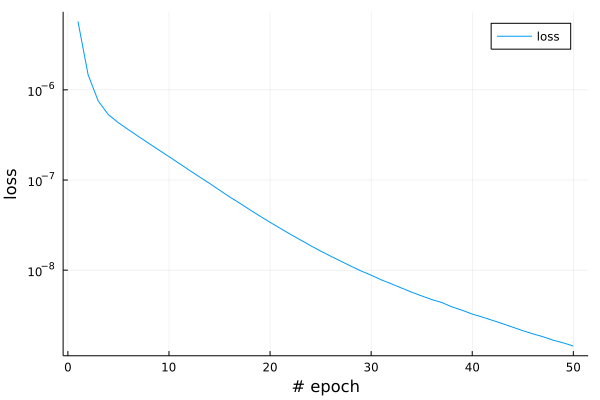

In [66]:
lossPlot = Plots.plot(lossEvolution, label="loss", yaxis=:log)

# add annotation
Plots.xlabel!(lossPlot, "# epoch")
Plots.ylabel!(lossPlot, "loss")

In [67]:
model[1][6].kn

3-element Vector{Float64}:
 0.0
 0.0
 0.0021517959454783126

In [68]:
 model[1][8].kn

3-element Vector{Float64}:
 0.0
 0.3100285653384032
 0.0

In [69]:
 accelerator[1][8].kn

3-element Vector{Float64}:
 0.0
 0.3100082065838593
 0.0

# show trajectories after training

In [70]:
trajectory = reduce(hcat, Flux.activations(accelerator, particle));
predicted = reduce(hcat, Flux.activations(model, particle));

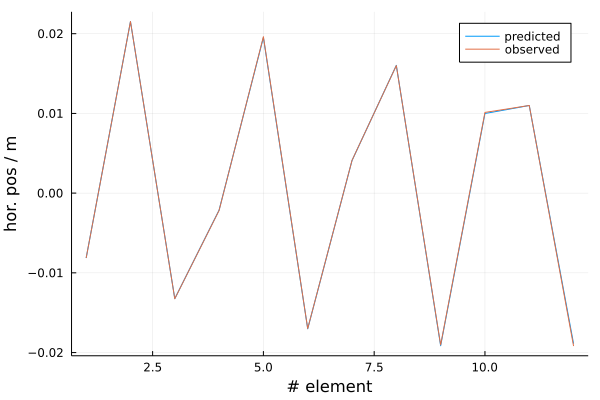

In [71]:
trajAfter = Plots.plot(predicted[1, :], label="predicted")
Plots.plot!(trajAfter, trajectory[1, :], label="observed")

# add annotation
Plots.xlabel!(trajAfter, "# element")
Plots.ylabel!(trajAfter, "hor. pos / m")

# debug